# Попытка понять как работают лаги и как навесить на них внешние факторы

Основано на https://github.com/technogleb/ts_march_2023/blob/main/week_2/modern_approach.ipynb 

In [134]:
#!pip install isodate
#!pip install bokeh
#!pip install MonthDelta
#!pip install tensorflow
import warnings
import isodate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import math
from pandas._libs.tslibs.timestamps import Timestamp


from sklearn.linear_model import LinearRegression

from parser.gdp import get_gdp_dataframe
from data_transform.transform_df import transform_df_to_format
from parser.loans_volume_msp import get_loans_volume_msp_df
from parser.broad_money_supply import get_broad_money_supply
from lags.plotting import plot_ts
import lags.model as m

warnings.filterwarnings('ignore')

Вспомогательные функции:

In [135]:
def mape( actual , pred ): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual))* 100

Подготовка датафрейма:

In [136]:
df = transform_df_to_format(get_loans_volume_msp_df(2019, 2024, spikes_remove=False))

# Извлекаем год из столбца "Отчетный период"
df['date'] = df['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
df['date'] = df['date'].astype(str) + '-' + df['month_n'].astype(str)
df['date'] = pd.to_datetime(df['date'])

# Удаляем временные столбцы
df = df[['date', 'msp_loans_volume']]
df = df.reset_index()
df = df.drop('index', axis = 1)
df

,date,msp_loans_volume
0,2019-01-01,452992.0
1,2019-02-01,482114.0
2,2019-03-01,604402.0
3,2019-04-01,686986.0
4,2019-05-01,585284.0
...,...,...
59,2023-12-01,1854476.0
60,2024-01-01,935130.0
61,2024-02-01,1216737.0
62,2024-03-01,1524903.0


Посмотрим на данные:

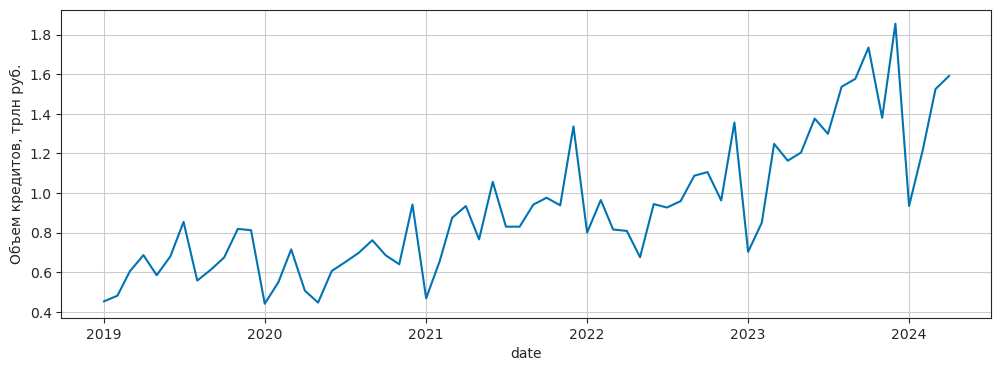

In [137]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

Разделим данные на train и test выборки:

In [138]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size
print("train_size = ", train_size)
print("test_size = ", test_size)

split_date = df['date'].iloc[train_size]
print(split_date)

# разделение данных на тестовые и тренировочные
train = df[df['date']<split_date]
test = df[df['date']>=split_date]

# Делаем из датафреймов серии

trn_ser = train.copy()
trn_ser.set_index(keys='date', drop=True, inplace=True)
trn_ser = trn_ser.squeeze(axis=1)

tst_ser = test.copy()
tst_ser.set_index(keys='date', drop=True, inplace=True)
tst_ser = tst_ser.squeeze(axis=1)

train_size =  54
test_size =  10
2023-07-01 00:00:00


In [139]:
ts = trn_ser

Зададим гранулярность. Гранулярность - частота временного ряда, задается в согласии с форматов iso6801

In [140]:
granularity = 'P1M'  # 1 месяц

isodate.parse_duration(granularity)

isodate.duration.Duration(0, 0, 0, years=0, months=1)

Зададим ширину окна

In [141]:
num_lags = 12

Зададим модель

In [142]:
Model = LinearRegression

In [143]:
predictor = m.TimeSeriesPredictor(
    granularity=granularity,
    num_lags=num_lags,
    model=Model
)

In [144]:
lags_matrix = predictor.transform_into_matrix(ts)

In [145]:
lags_matrix[:10]

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0
date,,,,,,,,,,,,,
2020-01-01,452992.0,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0
2020-02-01,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0
2020-03-01,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0
2020-04-01,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0
2020-05-01,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0
2020-06-01,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0
2020-07-01,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0
2020-08-01,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0
2020-09-01,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,761853.0


## Обучение модели и получение предсказания

In [146]:
predictor.fit(ts)

In [147]:
prediction = predictor.predict_next(ts, n_steps=(test_size))
prediction

2023-07-01    1.187339e+06
2023-08-01    1.256920e+06
2023-09-01    1.183468e+06
2023-10-01    1.114297e+06
2023-11-01    1.085261e+06
2023-12-01    1.584465e+06
2024-01-01    1.258526e+06
2024-02-01    1.246418e+06
2024-03-01    1.502371e+06
2024-04-01    1.334480e+06
dtype: float64

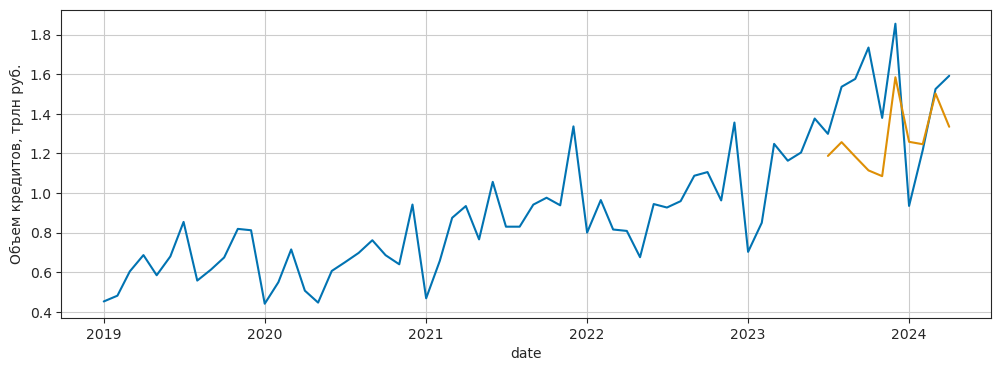

In [148]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(prediction / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

In [149]:
mape(tst_ser.values, prediction.values)

17.79592880381827

## Зададим сторонние признаки

In [150]:
def get_month_sin(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.sin(theta)


def get_month_cos(timestamp: Timestamp) -> float:
    theta = timestamp.month * (2*math.pi / 12)
    return math.cos(theta)

In [151]:
datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos
}

Добавим сторонние признаки

In [152]:
predictor = m.TimeSeriesPredictor(
    granularity=granularity,
    num_lags=num_lags,
    model=Model,
    mappers=datetime_mappers,
)

In [153]:
"""
        Adds external features to time series

        Parameters
        ------------
        lags_matrix
            Pandas dataframe with transformed time-series values
        mappers
            Dictionary of functions to map each timestamp of lags matrix.
            Each function should take timestamp as the only positional parameter
            and return value of your additional feature for that timestamp
"""

feature_matrix = predictor.enrich(lags_matrix)
feature_matrix

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,month_sin,month_cos
date,,,,,,,,,,,,,,,
2020-01-01,452992.0,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,5.000000e-01,8.660254e-01
2020-02-01,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,8.660254e-01,5.000000e-01
2020-03-01,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,1.000000e+00,6.123234e-17
2020-04-01,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,8.660254e-01,-5.000000e-01
2020-05-01,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,5.000000e-01,-8.660254e-01
2020-06-01,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,1.224647e-16,-1.000000e+00
2020-07-01,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,-5.000000e-01,-8.660254e-01
2020-08-01,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,-8.660254e-01,-5.000000e-01
2020-09-01,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,761853.0,-1.000000e+00,-1.836970e-16


In [154]:
predictor.mappers

{'month_sin': <function __main__.get_month_sin(timestamp: pandas._libs.tslibs.timestamps.Timestamp) -> float>,
 'month_cos': <function __main__.get_month_cos(timestamp: pandas._libs.tslibs.timestamps.Timestamp) -> float>}

In [155]:
feature_matrix

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,month_sin,month_cos
date,,,,,,,,,,,,,,,
2020-01-01,452992.0,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,5.000000e-01,8.660254e-01
2020-02-01,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,8.660254e-01,5.000000e-01
2020-03-01,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,1.000000e+00,6.123234e-17
2020-04-01,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,8.660254e-01,-5.000000e-01
2020-05-01,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,5.000000e-01,-8.660254e-01
2020-06-01,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,1.224647e-16,-1.000000e+00
2020-07-01,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,-5.000000e-01,-8.660254e-01
2020-08-01,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,-8.660254e-01,-5.000000e-01
2020-09-01,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,761853.0,-1.000000e+00,-1.836970e-16


In [156]:
predictor.fit(ts)

prediction = predictor.predict_next(ts, n_steps=(test_size))
prediction

2023-07-01    1.232902e+06
2023-08-01    1.349779e+06
2023-09-01    1.315106e+06
2023-10-01    1.277576e+06
2023-11-01    1.248472e+06
2023-12-01    1.714467e+06
2024-01-01    1.348035e+06
2024-02-01    1.277359e+06
2024-03-01    1.508411e+06
2024-04-01    1.361987e+06
dtype: float64

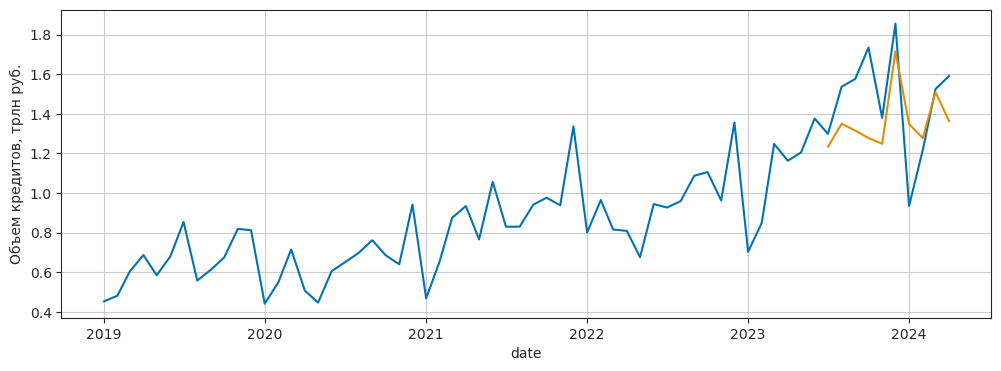

In [157]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(prediction / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

In [158]:
mape(tst_ser.values, prediction.values)

14.178725716792123

In [164]:
broad_money_supply = transform_df_to_format(get_broad_money_supply(2019, 2024))

# Извлекаем год из столбца "Отчетный период"
broad_money_supply['date'] = broad_money_supply['Отчетный период'].str.extract(r'(\d{4})').astype(int)

# Формируем новый столбец "Дата" в формате YYYY-MM
broad_money_supply['date'] = broad_money_supply['date'].astype(str) + '-' + broad_money_supply['month_n'].astype(str)
broad_money_supply['date'] = pd.to_datetime(broad_money_supply['date'])

# Удаляем временные столбцы
broad_money_supply = broad_money_supply[['date', 'broad_money']]
broad_money_supply = broad_money_supply.reset_index()
broad_money_supply = broad_money_supply.drop('index', axis = 1)

#broad_money_supply.set_index(keys='date', drop=True, inplace=True)
broad_money_supply

,date,broad_money
0,2019-01-01,59779.4
1,2019-02-01,60469.3
2,2019-03-01,60146.8
3,2019-04-01,60481.3
4,2019-05-01,60959.4
...,...,...
59,2023-12-01,112483.1
60,2024-01-01,111777.1
61,2024-02-01,113844.5
62,2024-03-01,114105.6


In [176]:
def get_broad_money(timestamp: Timestamp) -> float:
    n = broad_money_supply.index[broad_money_supply['date'] == timestamp]
    broad_money = broad_money_supply.iloc[n[0]]
    return broad_money[1]

In [177]:
x = get_broad_money(Timestamp('2024-03-01 00:00:00', freq='MS'))
x

114105.6

In [178]:
datetime_mappers = {
    'month_sin': get_month_sin,
    'month_cos': get_month_cos,
    'broad_money' : get_broad_money
}

In [179]:
predictor = m.TimeSeriesPredictor(
    granularity=granularity,
    num_lags=num_lags,
    model=Model,
    mappers=datetime_mappers,
)

In [180]:
feature_matrix = predictor.enrich(lags_matrix)
feature_matrix

,lag_12,lag_11,lag_10,lag_9,lag_8,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,lag_0,month_sin,month_cos,broad_money
date,,,,,,,,,,,,,,,,
2020-01-01,452992.0,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,5.000000e-01,8.660254e-01,63918.1
2020-02-01,482114.0,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,8.660254e-01,5.000000e-01,65483.6
2020-03-01,604402.0,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,1.000000e+00,6.123234e-17,68322.7
2020-04-01,686986.0,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,8.660254e-01,-5.000000e-01,68158.2
2020-05-01,585284.0,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,5.000000e-01,-8.660254e-01,67856.3
2020-06-01,680248.0,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,1.224647e-16,-1.000000e+00,68709.8
2020-07-01,854372.0,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,-5.000000e-01,-8.660254e-01,69794.9
2020-08-01,558370.0,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,-8.660254e-01,-5.000000e-01,70823.1
2020-09-01,613515.0,674912.0,819205.0,812275.0,441552.0,550189.0,715515.0,507464.0,447268.0,606903.0,650851.0,698027.0,761853.0,-1.000000e+00,-1.836970e-16,72457.7


In [181]:
predictor.mappers

{'month_sin': <function __main__.get_month_sin(timestamp: pandas._libs.tslibs.timestamps.Timestamp) -> float>,
 'month_cos': <function __main__.get_month_cos(timestamp: pandas._libs.tslibs.timestamps.Timestamp) -> float>,
 'broad_money': <function __main__.get_broad_money(timestamp: pandas._libs.tslibs.timestamps.Timestamp) -> float>}

In [182]:
predictor.fit(ts)

prediction = predictor.predict_next(ts, n_steps=(test_size))
prediction

2023-07-01    1.330319e+06
2023-08-01    1.435102e+06
2023-09-01    1.407678e+06
2023-10-01    1.348728e+06
2023-11-01    1.302903e+06
2023-12-01    1.775879e+06
2024-01-01    1.424870e+06
2024-02-01    1.352353e+06
2024-03-01    1.552365e+06
2024-04-01    1.486462e+06
dtype: float64

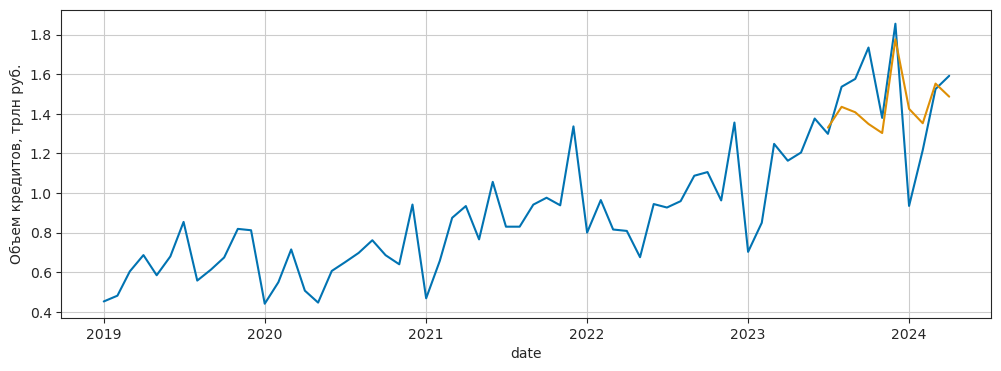

In [183]:
plt.figure(figsize=(12, 4))
plt.plot(df['date'], df['msp_loans_volume'].values/ 1e6)
plt.plot(prediction / 1e6)
plt.xlabel('date')
plt.ylabel('Объем кредитов, трлн руб.')
plt.grid(True)
plt.show()

In [184]:
mape(tst_ser.values, prediction.values)

12.363785109650626